<a href="https://colab.research.google.com/github/steelannelida/nanoGPT/blob/master/nanogpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/steelannelida/nanoGPT.git

fatal: destination path 'nanoGPT' already exists and is not an empty directory.


In [2]:
!pip install torch numpy transformers datasets tiktoken wandb tqdm triton


In [3]:
!yes  | python nanoGPT/data/shakespeare/prepare.py

train has 301,966 tokens
val has 36,059 tokens


In [4]:
with open('nanoGPT/data/shakespeare/input.txt') as f:
  text = f.read()

chars = sorted(set(text))
vocab_size=len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}

def encode(t):
  return [stoi[c] for c in t]

def decode(seq):
  return ''.join([chars[i] for i in seq])

decode(encode("sandwitch"))

'sandwitch'

In [5]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data = torch.tensor(encode(text), device=device)
data.shape, data.dtype

n = int(data.shape[0] * 0.9)
train_data = data[:n]
valid_data = data[n:]

In [6]:
#torch.manual_seed(1337)


def get_batch(data_set=train_data, batch_size=32, seq_length=128):
    x = torch.zeros([batch_size, seq_length], dtype=torch.int, device=device)
    y = torch.zeros([batch_size, seq_length], dtype=torch.int, device=device)
    for b in range(batch_size):
        t = torch.randint(0, data_set.shape[0] - seq_length - 1, [1])
        x[b] = data_set[t:t+seq_length]
        y[b] = data_set[t+1:t+seq_length+1]
    return x, y

x, y = get_batch()
print(decode(x[13]))
print(decode(y[13]))

t
Come up to the truth. So have we thought it good
From our free person she should be confined,
Lest that the treachery of the t

Come up to the truth. So have we thought it good
From our free person she should be confined,
Lest that the treachery of the tw


In [7]:
import torch.nn as nn

class DecoderLayer(nn.Module):
  def __init__(self, embed_size=256, wide_size=1024, nheads=16, dropout=0.5):
    super().__init__()
    # self.attn = nn.MultiheadAttention(embed_size, nheads,
    #                                   batch_first=True)
    self.nheads = nheads
    self.head_size = embed_size // nheads
    self.pre_attn = nn.Linear(embed_size, 3 * embed_size)
    self.post_attn = nn.Linear(embed_size, embed_size)
    self.ln1 = nn.LayerNorm(embed_size)
    self.ln2 = nn.LayerNorm(embed_size)
    self.lin1 = nn.Linear(embed_size, wide_size)
    self.lin2 = nn.Linear(wide_size, embed_size)
    self.drop = nn.Dropout(dropout)

  def forward(self, x, mask):
    N, L, C = x.shape
    x = self.ln1(x)
    #a, w = self.attn.forward(x, x, x, attn_mask=mask, is_causal=True)
    kqv = self.pre_attn(x).view(N, L, self.nheads, 3*self.head_size).permute(0, 2, 1, 3)
    k = kqv[:,:,:,:self.head_size]
    q = kqv[:,:,:,self.head_size : 2*self.head_size]
    v = kqv[:,:,:,2*self.head_size:]
    av = nn.functional.scaled_dot_product_attention(q, k, v, mask.view(1, L, L))
    a = self.post_attn(av.permute(0, 2, 1, 3).view(N, L, C))
    x = x + self.drop(a)
    x = self.ln2(x)
    xx = self.lin1(x)
    xx = nn.functional.gelu(xx)
    y = self.lin2(xx)
    return x + y

class RnnLayer(nn.Module):
  def __init__(self, embed_size=256, wide_size=1024, dropout=0.5, **kwargs):
    super().__init__()
    # self.attn = nn.MultiheadAttention(embed_size, nheads,
    #                                   batch_first=True)
    self.rnn = nn.LSTM(embed_size, embed_size)
    self.ln1 = nn.LayerNorm(embed_size)
    self.ln2 = nn.LayerNorm(embed_size)
    self.lin1 = nn.Linear(embed_size, wide_size)
    self.lin2 = nn.Linear(wide_size, embed_size)
    self.drop = nn.Dropout(dropout)

  def forward(self, x, mask):
    N, L, C = x.shape
    x = self.ln1(x)
    #a, w = self.attn.forward(x, x, x, attn_mask=mask, is_causal=True)
    a, h = self.rnn(x)
    x = x + self.drop(a)
    x = self.ln2(x)
    xx = self.lin1(x)
    xx = nn.functional.gelu(xx)
    y = self.lin2(xx)
    return x + y


class LM(nn.Module):
  def __init__(self, vocab_size, decoder=DecoderLayer, embed_size=256, nheads=16, max_pos=2048, num_layers=3, dropout=0.5):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, embed_size)
    self.pos_embeddings = nn.Embedding(max_pos, embed_size)
    self.layers = [
        decoder(embed_size=embed_size, wide_size=4 * embed_size,
                     nheads=nheads, dropout=dropout)
        for _ in range(num_layers)
    ]
    for i, layer in enumerate(self.layers):
      self.add_module(f'decoder-{i}', layer)
    self.ln = nn.LayerNorm(embed_size)
    self.out = nn.Linear(embed_size, vocab_size)
    self.max_pos = max_pos
    self.to(device)

  def forward(self, idx):
    idx = torch.tensor(idx, device=device)
    l = idx.shape[-1]
    pe = self.pos_embeddings(torch.arange(0, l, device=device))
    e = self.embeddings(idx)
    e = e + pe.view(1, *pe.shape)
    mask = torch.tril(torch.ones([l, l], dtype=torch.bool, device=device))
    #print(mask)
    #print(w)
    for layer in self.layers:
      e = layer(e, mask)
    logits = self.out.forward(self.ln(e))
    return logits

  def generate(self, prompt, l):
    prompt = torch.tensor(prompt)
    pl = prompt.shape[0]
    result = torch.zeros([pl + l], dtype=torch.int, device=device)
    result[:pl] = prompt
    for i in range(l):
      logits = self.forward(result[:pl + i])
      sm = logits[:,-1].flatten().softmax(0)
      next_idx = torch.multinomial(sm, 1)
      result[i+pl] = next_idx
    return result

model = LM(vocab_size)

k=x
q=x[:,:-1]
x, y = get_batch()
model.forward(x)
decode(model.generate(encode('hello'), 10))


<ipython-input-7-926c060b2b42>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.tensor(idx, device=device)


'hellomH-lwwv,?R'

In [8]:
x, y = get_batch()
logits = model(x)
loss_fun = nn.CrossEntropyLoss()
loss = loss_fun(logits.permute(0, 2, 1), y.long())
loss

<ipython-input-7-926c060b2b42>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.tensor(idx, device=device)


tensor(4.3366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [9]:
torch.manual_seed(1337)

model1 = LM(vocab_size, num_layers=8)
model2 = LM(vocab_size, decoder=RnnLayer, num_layers=8)
opt1 = torch.optim.AdamW(model1.parameters(), lr=1e-3)
opt2 = torch.optim.AdamW(model2.parameters(), lr=1e-3)
xv, yv = get_batch(valid_data, batch_size=256)
loss_history1 = []
loss_history2 = []

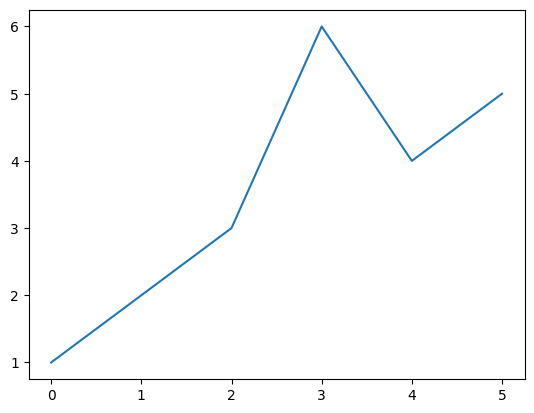

In [10]:
from matplotlib import pyplot as plt
import IPython.display as ipd

plt.plot([1,2,3,6,4,5])

In [14]:
%%time


torch.set_float32_matmul_precision('medium')
for step in range(5000):
  x, y = get_batch(batch_size=32, seq_length=128)
  with torch.autocast(device_type='cuda', dtype=torch.float16):
    model1.train()
    logits = model1.forward(x)
    loss1 = loss_fun(logits.permute(0, 2, 1), y.long())

    model2.train()
    logits = model2.forward(x)
    loss2 = loss_fun(logits.permute(0, 2, 1), y.long())

  loss1.backward()
  opt1.step()
  opt1.zero_grad()

  loss2.backward()
  opt2.step()
  opt2.zero_grad()


  if step % 10 == 0:
    with torch.no_grad():
      with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        model1.eval()
        vlogits = model1.forward(xv)
        vloss1 = loss_fun(vlogits.permute(0,2,1), yv.long())

        model2.eval()
        vlogits = model2.forward(xv)
        vloss2 = loss_fun(vlogits.permute(0,2,1), yv.long())

      loss_history1.append(float(vloss1))
      loss_history2.append(float(vloss2))

      plt.plot(loss_history1)
      plt.plot(loss_history2)
      ipd.clear_output(True)
      plt.show()

<ipython-input-7-926c060b2b42>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.tensor(idx, device=device)


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [12]:
with torch.no_grad():
  model2.eval()
  model2.forward(xv)

<ipython-input-7-926c060b2b42>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.tensor(idx, device=device)


In [13]:
with torch.profiler.profile(with_stack=True, profile_memory=True) as prof:
  x, y = get_batch(batch_size=32, seq_length=128)
  with torch.autocast(device_type='cuda', dtype=torch.float16):
    model.train()
    logits = model.forward(x)
    loss = loss_fun(logits.permute(0, 2, 1), y.long())

  loss.backward()
  opt.step()
  opt.zero_grad()


print(prof.export_chrome_trace('trace3.json'))


<ipython-input-7-926c060b2b42>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.tensor(idx, device=device)


NameError: name 'opt' is not defined

In [ ]:
!ls -lh trace2.json

In [ ]:
with torch.no_grad():
  with torch.autocast(device_type='cuda', dtype=torch.float16):
    model.eval()
    print(decode(model.generate(encode('To dream'), 256)))


In [ ]:
import matplotlib.pyplot as plt

#plt.imshow(model.embeddings.weight.detach().cpu().numpy())
plt.plot(model.pos_embeddings.weight[:,37].detach().cpu().numpy())
# plt.plot(model.pos_embeddings.weight[:,4].detach().cpu().numpy())


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE()
y = tsne.fit_transform(model.embeddings.weight.detach().T.cpu().numpy())

plt.scatter(y[:,0], y[:,1], s=1, alpha=0.1)
for i, c in enumerate(chars):
  plt.text(y[i,0], y[i,1], c)

In [ ]:
model.embeddings.weight.shape